In [41]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.optim import Adam
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

In [16]:
from GatedPixelCNN import PixelCNN


def discretize_imgs(img_tensor, nlevels):
    '''
    discretize a floating tensor to a discrete version into nlevels (quantization).
    The function assumes that the data is between [0,1]
    it return the two outputs; the first is again between [0,1] but only nlevels.
    The second is the equivalente but with integer indices between [0,nlevels-1]
    '''
    xnp=img_tensor.numpy()
    xnp_dig=(np.digitize(xnp, np.arange(nlevels) / nlevels) - 1).astype(np.long)
    xnp=xnp_dig/(nlevels -1)
    return torch.from_numpy(xnp).float(), torch.from_numpy(xnp_dig)
    

# Data

In [5]:

#mod this as needed
batch_size=64
num_workers=8
##############


transform = transforms.Compose([
        transforms.ToTensor(),
    ])
train_dataset = MNIST('DATA', download=True, train=True, transform=transform)



train_loader = torch.utils.data.DataLoader(train_dataset,
        batch_size=batch_size, shuffle=True,
        num_workers=num_workers, pin_memory=True)


# Params for training

In [58]:
show_every=100 # show info every this number of iterations
nlayers=12 # number of layers for pixelcnn
inchans=1 #number of input channels (currently only one is supported)
nfeats=16 #number of feature maps across the network
Klevels=4 #number of levels to use in discretization
nepochs=5 #number of epochs to train
lr=1e-3 #learning rate for optimizer
generate_every=300
nimgs_to_generate=16

In [51]:
def generate_imgs(model, shape, nimgs):
    x=torch.zeros((nimgs,1,shape[0],shape[1])).cuda()
    logits=model(x)
    model.eval()
    for i in range(x.shape[2]):
        for j in range(x.shape[3]):
            logits=model(x)
            probs=torch.softmax(logits[:,:,i,j],1)
            sample=probs.multinomial(1)
            x[:,:,i,j]=sample.float()/(Klevels-1)
    model.train()
    return x.cpu()

In [52]:
model=PixelCNN(nlayers=nlayers, in_channels=inchans, nfeats=nfeats, Klevels=Klevels).cuda()

In [59]:
optimizer = Adam(model.parameters(), lr=lr, betas=(0, 0.99))
criteria=nn.CrossEntropyLoss()

list_imgs=[]
for epoch in range(nepochs):
    for it,(images, labels) in enumerate(train_loader):

        imgs,imgs_quant= discretize_imgs(images, Klevels)
        imgs=imgs.cuda()
        imgs_quant=imgs_quant.cuda()
        logits=model(imgs)
        loss=criteria(logits,imgs_quant.squeeze())
        optimizer.zero_grad() # Backward & update weights
        loss.backward()
        optimizer.step()
        
        if it%show_every==0:
            print(f'epoch: {epoch}, it:{it}/{len(train_loader)}, loss:{loss.item()}')
        if it%generate_every==0:
            print('generating imgs...')
            samples=generate_imgs(model, (imgs.shape[2],imgs.shape[3]), nimgs_to_generate)
            list_imgs.append(samples)

epoch: 0, it:0/938, loss:0.17039287090301514
generating imgs...
epoch: 0, it:100/938, loss:0.16692976653575897
epoch: 0, it:200/938, loss:0.16180896759033203
epoch: 0, it:300/938, loss:0.15814168751239777
generating imgs...
epoch: 0, it:400/938, loss:0.15354761481285095
epoch: 0, it:500/938, loss:0.15709513425827026
epoch: 0, it:600/938, loss:0.1586061269044876
generating imgs...
epoch: 0, it:700/938, loss:0.16148225963115692
epoch: 0, it:800/938, loss:0.15922556817531586
epoch: 0, it:900/938, loss:0.15367047488689423
generating imgs...
epoch: 1, it:0/938, loss:0.1491248607635498
generating imgs...
epoch: 1, it:100/938, loss:0.1527172327041626
epoch: 1, it:200/938, loss:0.14044855535030365
epoch: 1, it:300/938, loss:0.15388056635856628
generating imgs...
epoch: 1, it:400/938, loss:0.15040720999240875
epoch: 1, it:500/938, loss:0.150235116481781
epoch: 1, it:600/938, loss:0.15065419673919678
generating imgs...
epoch: 1, it:700/938, loss:0.15501564741134644
epoch: 1, it:800/938, loss:0.1

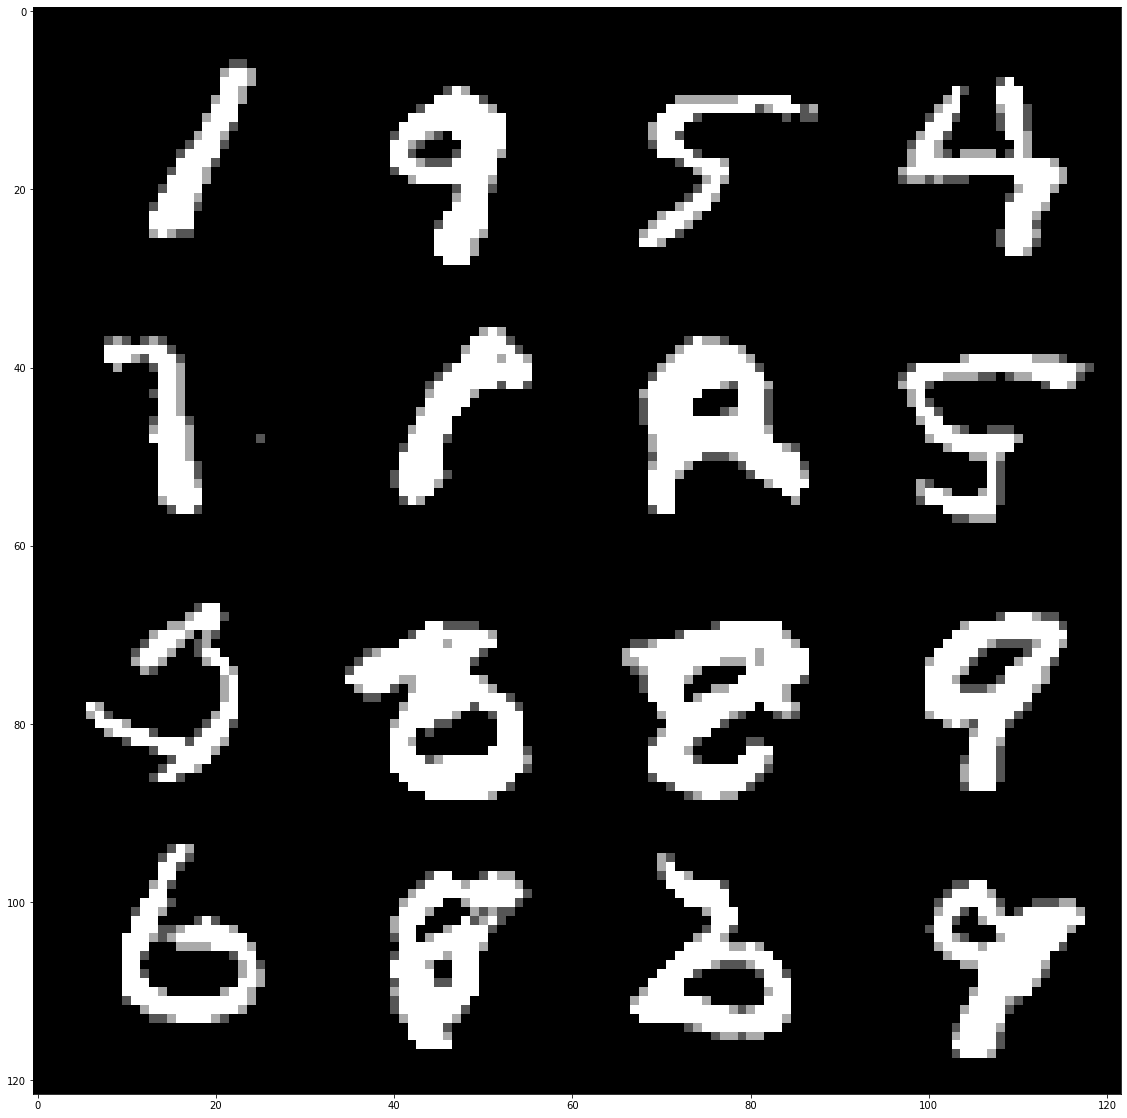

In [66]:
#show the last set of imags generated
def show(img):
    fig, ax=plt.subplots(figsize=(20,20))
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

tmp=make_grid(list_imgs[-1], nrow=4)
show(tmp)

In [2]:
#Make gif animation
from matplotlib.animation import FuncAnimation
print(len(list_imgs))
fig, ax=plt.subplots(figsize=(20,20))
def gen_grid(i):
    print(f'frame {i}')
    img=make_grid(list_imgs[i], nrow=4)
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    ax.set_title(f'iteration {i*generate_every}', fontsize=50)
    
    

anim = FuncAnimation(fig, gen_grid, frames=np.arange(len(list_imgs)), interval=500)
anim.save('digits.gif', dpi=80, writer='imagemagick')
plt.close()